# Long Call Option

### I. Strategy Overview

#### Payoff

![](long_call.jpg)

#### Features:
* Long Delta: option value increases as the underlying price goes up
* Short Theta: option value decreases as time decays
* Long volatility: option value increases as the implied volatility hikes

### II. Strategy Setup

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
# from Functions.OptionBasics import StrategyPerformance
from Functions.Backtest import GetExpiration, GetPayOff, GetBackTesting

####  1. Input symbol of underlying

In [2]:
Ticker = 'MSFT'

#### 2. Specify testing period and find out the expiration dates within

In [3]:
Start_Date = datetime.datetime(2017, 1, 4)
End_Date = datetime.datetime(2018,3, 1)

expiry = GetExpiration(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [4]:
expiry

,Trading Day,Day of the Week,Year-Month,Expiration
0,2017-01-20,Friday,2017-01,1
1,2017-02-17,Friday,2017-02,1
2,2017-03-17,Friday,2017-03,1
3,2017-04-28,Friday,2017-04,1
4,2017-05-19,Friday,2017-05,1
5,2017-06-16,Friday,2017-06,1
6,2017-07-21,Friday,2017-07,1
7,2017-08-18,Friday,2017-08,1
8,2017-09-15,Friday,2017-09,1
9,2017-10-20,Friday,2017-10,1


#### 3. Choose option expiration and  enter dates

In [5]:
entry_date = datetime.datetime(2017, 1, 4)
expiration = [datetime.datetime(2017, 3, 18)]
exit_date = datetime.datetime(2017, 3, 4)

#### 4. Option Type & Strike Price Selection
* Change the strike price to see how it affects the strategy

In [6]:
option_type = ['P']
action = ['S']
# strike_price = 55  # At the money
strike_price = [64]  # Deep in the money
# strike_price = 65  # Far out of the money

### III. Visualization
#### 1. Generate options basic data

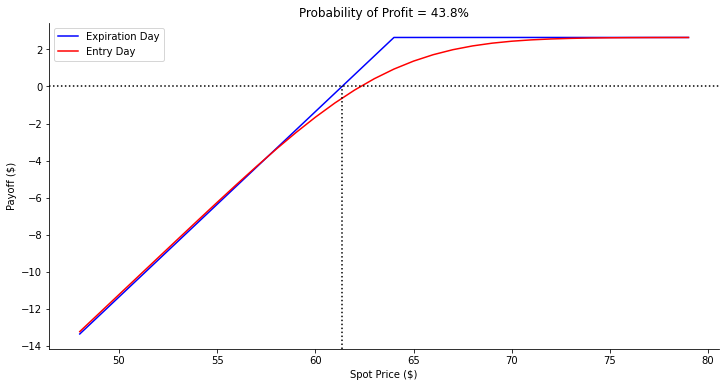

In [7]:
payoff = GetPayOff(Ticker, strike_price[0], entry_date, expiration[0], option_type[0], action[0])
payoff.plot_payoff()


#### 3. Actual Price and Volatility Moves

In [8]:
# viz = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv,[],[],[],[],[],[])
bt = GetBackTesting(Ticker, strike_price[0], entry_date, exit_date, option_type[0], action[0], expiration[0])

#### 4. Returns

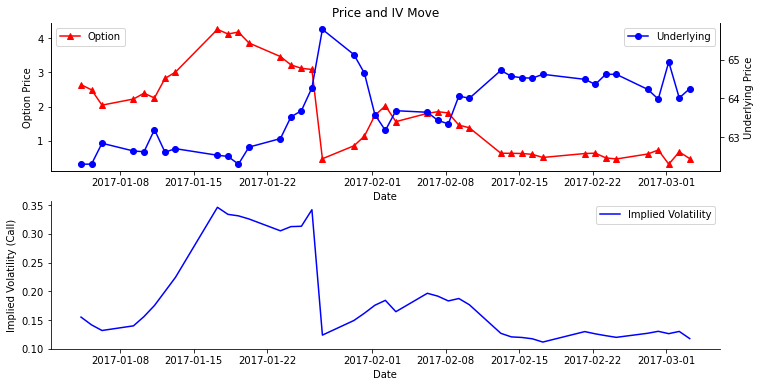

In [9]:
bt.plot_price_history()

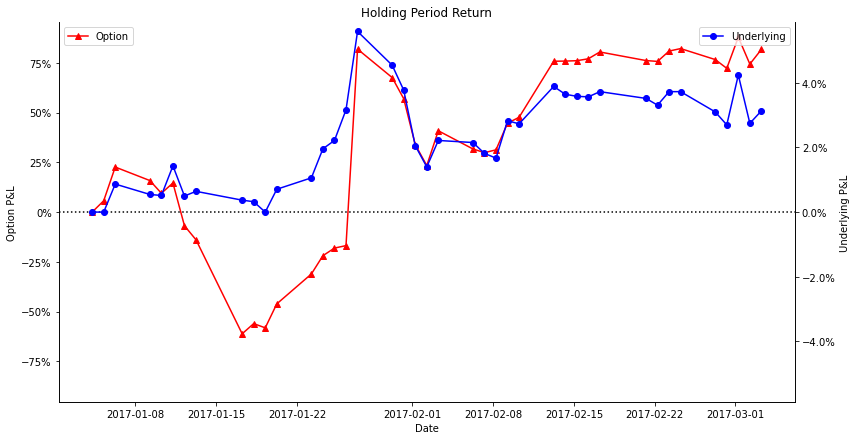

In [10]:
bt.plot_option_pnl()

### IV. Trade Journaling

In [12]:
# payoff_calc.print_strategy_summary()
bt.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2017-01-04,$264.28,2017-03-04,59,$48.20,$216.08,$3.66,81.8%,True


### V. Recurring Strategy Setup
Get in when:
Simplified
* 1st trading day of every month
* Buy next month's expiration

Realistic:
* IV < 0
* Expiration date < 60 & Expiration date > 60
* VIX < 20

In [ ]:
import pandas as pd
trading_days['Year-Month'] = trading_days['Date'].dt.to_period('M') + 1  # +1 to find the expiration date in the next month
dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Trading Day']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

In [ ]:
from datetime import timedelta
entry_dates = dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True)
expiration_dates = dte_seeker[dte_seeker['DTE']==43]['Trading Day'].reset_index(drop=True)
exit_dates = entry_dates + timedelta(days=22)

# exit_dates = dte_seeker[(dte_seeker['DTE']==21)]['Date']
# exit_dates[exit_dates>entry_dates[0]].reset_index(drop=True)

entry_dates

In [ ]:
exit_dates

In [ ]:
expiration_dates

In [ ]:
import pandas as pd
expiration_dates = pd.to_datetime(expiration_dates)

In [ ]:
strategy_performance = pd.DataFrame([])
i = 0
strike_price = 55
for _ in entry_dates:
    option_data = OptionBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    option_price, option_return, underlying_price, underlying_return, trading_days, iv, hv = option_data.generate_data()
    payoff_calc = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], lower_limit, upper_limit, option_type, action)
    payoff_calc.print_strategy_summary()
    strategy_performance = strategy_performance.append(payoff_calc.strategy_summary)
    i+=1
    strike_price = underlying_price['close'][-1]+5

In [ ]:
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))
# Total_Cost = "${:,.2f}".format(strategy_performance['Cost Basis'].sum())

In [ ]:
win_rate

In [ ]:
strategy_performance